In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import dowhy.gcm as gcm
from castle.algorithms import PC
from castle.algorithms.pc.pc import find_skeleton
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

2024-03-04 09:00:16,805 - c:\Users\ryan.sullivan\OneDrive - Entain Group\Documents\ryan\repo\personal\causal_graphs\venv\Lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-03-04 09:00:16,922 - c:\Users\ryan.sullivan\OneDrive - Entain Group\Documents\ryan\repo\personal\causal_graphs\venv\Lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [4]:
def plot_graph(input_graph, node_lookup):
    '''
    Function to visualise graphs.

    Args:
        input_graph (array): Adjacency matrix representing graph
        node_lookup (dict): Dictionary containing node names.
    '''
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(8,8))
    nx.draw(
    G=graph,
    node_color=COLORS[0],
    node_size=8000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=9,
    pos=nx.circular_layout(graph)
    )

# <ins>Introduction</ins>

This notebook aims to help you navigate the world of causal discovery.

**It is aimed at anyone who wants to understand more about:**
- What causal discovery is, including what assumptions it makes.
- A deep dive into conditional independence tests, the building blocks of causal discovery.
- An overview of the PC algorithm, a popular causal discovery algorithm.
- A worked case study in Python illustrating how to apply the PC algorithm.
- Guidance on making causal discovery work in real-world business settings.

# <ins>What is causal discovery?</ins>

In my last notebook, I covered how causal graphs could be used to answer causal questions. 

Often referred to as a DAG (directed acyclic graph), a causal graph contains nodes and edges - Edges link nodes that causally related. 

There are two ways to determine a causal graph:
- Expert domain knowledge
- Causal discovery algorithms

We don't always have the expert domain knowledge to determine a causal graph. In this notebook we will explore how to take observational data and determine the causal graph using causal discovery algorithms.

# <ins>Causal discovery algorithms</ins>

Causal discovery is a heavily researched area in academia with four groups of methods proposed:

| Method           | Description                                                                                                                                        |
| -----------------| ---------------------------------------------------------------------------------------------------------------------------------------------------|
| Constraint-based | Starts with a fully connected graph and then uses conditional-independence tests to remove edges                                                   |
| Score-based	   | Starts with a disconnected graph and iteratively adds new edges computing a score to assess how well the lastest iteration models the distribution |
| Function-based   | Leverages information about functional forms and properties of distributions to identify causal directions                                         |
| Gradient-based   | Essentially a score-based method but treated as a continually optimised task                                                                       |

It isn't clear from currently available research which method is best. One of the challenges in answering this question is the lack of realistic ground truth benchmark datasets.

In this blog we are going to focus on understanding the PC algorithm, a constraint-based method that uses conditional independence tests.

# <ins>Assumptions</ins>

Before we introduce the PC algorithm, let's cover the key assumptions made by causal discovery algorithms:

1) **Causal Markov Condition:** Each variable is conditionally independent of its non-descendants, given its direct causes. This tells us that if we know the causes of a variable, we don't gain any additional power by knowing the variables that are not directly influenced by those causes. This fundamental assumption simplifies the modelling of causal relationships enabling us to make causal inferences.
2) **Causal Faithfulness:** If statistical independence holds in the data, then there is no direct causal relationships between the corresponding variables. Testing this assumption is challenging and violations may indicate model misspecification or missing variables.
3) **Causal Sufficiency:** Are the variables included sufficient to make causal claims about the variables of interest? In other words, we need all confounders of the variables included to be observed. Testing this assumption involves sensitivity analysis which assesses the impact of potentially unobserved confounders.
4) **Acyclicity:** No cycles in the graph.

In practice, while these assumptions are necessary for causal discovery, they are often treated as assumptions rather than directly tested.

Even with making these assumptions, we can end up with a Markov equivalence class. We have a Markov equivalence class when we have multiple causal graphs each as likely as each other.

# <ins>Conditional independence tests</ins>

Conditional independence tests are the building blocks of causal discovery and are used by the PC algorithm (which we will cover shortly).

Let's start by understanding independence. Independence between two variables implies that knowing the value of one variable provides no information about the value of the other. In this case, it is fairly safe to assume that neither directly causes the other. However, if two variables aren't independent, it would be wrong to blindly assume causation.

Conditional independence tests can be used to determine whether two variables are independent of each other given the presence of one or more other variables. If two variables are conditionally independent, we can then infer that they are not causally related.

The Fisher's exact test can be used to determine if there is a significant association between two variables whilst controlling for the effects of one or more additional variables (use the additional variables to split the data into subsets, the test can then be applied to each subset of data). The null hypothesis assumes that there is no association between the two variables of interest. A p-value can then be calculated and if it is below 0.05 the null hypothesis will be rejected suggesting that there is significant association between the variables.

# <ins>Identifying spurious correlations</ins>

We can use an example of a spurious correlation to illustrate how to use conditional independence tests.

Two variables have a spurious correlation when they have a common cause e.g. High temperatures increasing the number of ice cream sales and shark attacks.

In [3]:
np.random.seed(999)

# Create dataset with spurious correlation
temperature = np.random.normal(loc=0, scale=1, size=1000)
ice_cream_sales = 2.5 * temperature + np.random.normal(loc=0, scale=1, size=1000)
shark_attacks = 0.5 * temperature + np.random.normal(loc=0, scale=1, size=1000)
df_spurious = pd.DataFrame(data=dict(temperature=temperature, ice_cream_sales=ice_cream_sales, shark_attacks=shark_attacks))
df_spurious

,temperature,ice_cream_sales,shark_attacks
0,0.127158,1.786089,-1.258475
1,1.401891,4.569047,0.014732
2,0.314815,-0.006379,0.343632
3,-0.858449,-2.596508,-0.095955
4,-0.266134,-0.879307,-0.852838
...,...,...,...
995,0.345351,2.691600,1.361264
996,-0.800185,0.556327,-0.814044
997,0.881674,1.954808,-0.087632
998,-1.691404,-4.698386,0.628715


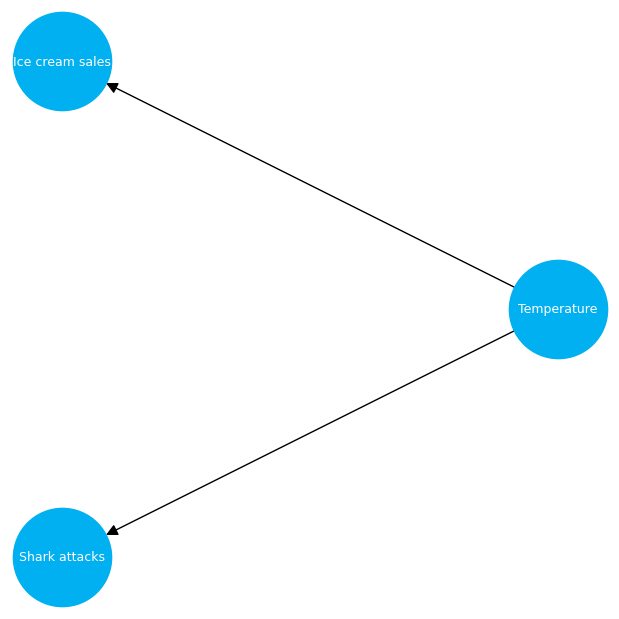

In [26]:
# Create node lookup variables
node_lookup = {0: 'Temperature',
               1: 'Ice cream sales',
               2: 'Shark attacks'                                                                          
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the base for our graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create graph using expert domain knowledge
graph_actual[0, 1] = 1.0 # Temperature -> Ice cream sales
graph_actual[0, 2] = 1.0 # Temperature -> Shark attacks
     
plot_graph(input_graph=graph_actual, node_lookup=node_lookup)

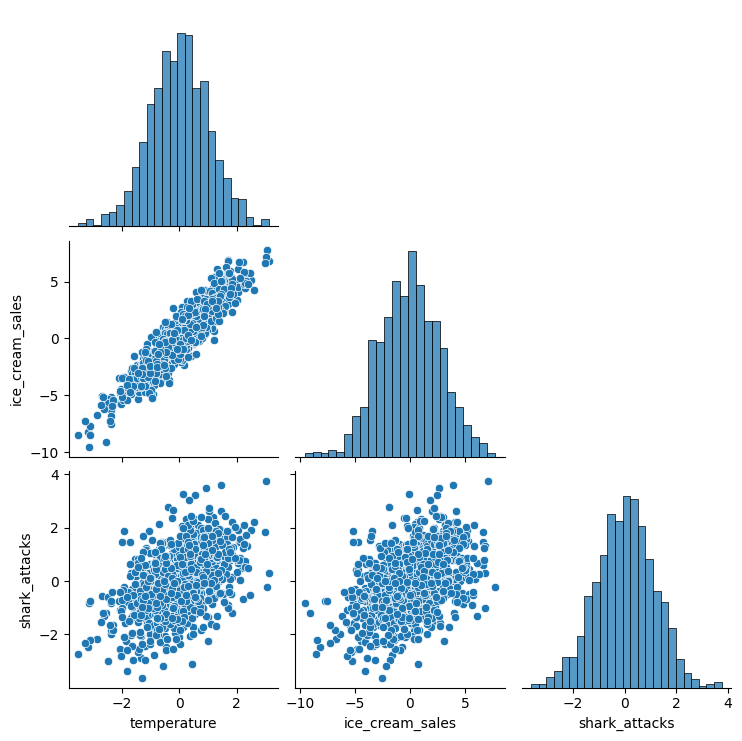

In [4]:
sns.pairplot(df_spurious, corner=True)

In [5]:
# Run first conditional independence test
round(gcm.independence_test(ice_cream_sales, shark_attacks, conditioned_on=temperature), 2)

In [6]:
# Run second conditional independence test
round(gcm.independence_test(ice_cream_sales, temperature, conditioned_on=shark_attacks), 2)

In [7]:
# Run third conditional independence test
round(gcm.independence_test(shark_attacks, temperature, conditioned_on=ice_cream_sales), 2)

The following conditional independence tests can be used to determine the causal graph:

|Test ID|Null Hypothesis|Variable A|Variable B|Conditioning Variable|p-value|Result|
|-|-|-|-|-|-|-|
|1|No association between ice cream sales and shark attacks|Ice cream sales|Shark attacks|Temperature|0.49|Accept null hypothesis|
|2|No association between ice cream sales and temperature|Ice cream sales|Temperature|Shark attacks|0.00|Reject null hypothesis|
|3|No association between shark attacks and temperature|Shark Attacks|Temperature|Ice cream sales|0.00|Reject null hypothesis|

Although we don't know the direction of the relationships, we can correctly infer that temperature is causally related to both ice cream sales and shark attacks.

# <ins>PC algorithm</ins>
The PC algorithm (named after its inventors Peter and Clark) is a constraint-based causal discovery algorithm that uses conditional independence tests. 

It can be summarised into 2 main steps:
1. It starts with a fully connected graph and then uses conditional independence tests to remove edges and identify the undirected causal graph (nodes linked but with no direction).
2. It then (partially) directs the edges using various orientation tricks.

We can use the previous spurious correlation example to illustrate the first step:
- Start with a fully connected graph
- Test ID 1: Accept the null hypothesis and delete edge, no causal link between ice cream sales and shark attacks
- Test ID 2: Reject the null hypothesis and keep the edge, causal link between ice cream sales and temperature
- Test ID 3: Reject the  null hypothesis and keep the edge, causal link between shark attacks and ice cream sales

# <ins>Evaluating results</ins>

One of the key challenges in causal discovery is evaluating the results. If we knew the causal graph, we wouldn't need to apply a causal discovery algorithm! However, we can create synthetic datasets to evaluate how well causal discovery algorithms perform. 

There are serveral metrics we can use to evaluate causal discovery algorithms:

$$
\ {FalseDiscoveryRate} = \frac{ReversedEdges + FalsePositives}{TruePositives + FalsePositives}
$$

$$
\ {TruePositiveRate} = \frac{TruePositives}{TruePositives + FalseNegatives}
$$

$$
\ {FalsePositiveRate} = \frac{ReversedEdges + FalsePositives}{TrueNegatives + FalsePositives}
$$

$$
\ {GScore} = \frac{TruePositives - FalsePositives}{TruePositives + FalseNegatives}
$$

- True positives: Identify causal link correctly
- False positives: Identify causal link incorrectly
- True negatives: Correctly identify no causal link
- False negatives: Incorrectly identify no causal link
- Reversed edges: Identify causal link correctly but in the wrong direction

 We want a high number of True positives, but this should not be at the expense of a high number of False positives (as when we come to build an SCM, wrong causal links can be very damaging). Therefore GScore seems to capture this well whilst giving an interpretable ratio between 0 and 1.

# <ins>Call centre case study</ins>

We will revisit the call centre case study from my previous article. First of all, we determine the causal graph (to be used as ground truth) and then use our knowledge of the data-generating process to create some samples.

The ground truth causal graph and generated samples will enable us to evaluate the PC algorithm.

In [2]:
# Create node lookup for channels
node_lookup = {0: 'Demand',
               1: 'Call waiting time',
               2: 'Call abandoned', 
               3: 'Reported problems',                   
               4: 'Discount sent',
               5: 'Churn'                                                                             
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the base for our graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create graph using expert domain knowledge
graph_actual[0, 1] = 1.0 # Demand -> Call waiting time
graph_actual[0, 2] = 1.0 # Demand -> Call abandoned
graph_actual[0, 3] = 1.0 # Demand -> Reported problems
graph_actual[1, 2] = 1.0 # Call waiting time -> Call abandoned
graph_actual[1, 5] = 1.0 # Call waiting time -> Churn
graph_actual[2, 3] = 1.0 # Call abandoned -> Reported problems
graph_actual[2, 5] = 1.0 # Call abandoned -> Churn
graph_actual[3, 4] = 1.0 # Reported problems -> Discount sent
graph_actual[3, 5] = 1.0 # Reported problems -> Churn
graph_actual[4, 5] = 1.0 # Discount sent -> Churn
     
graph_actual

array([[0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.]])

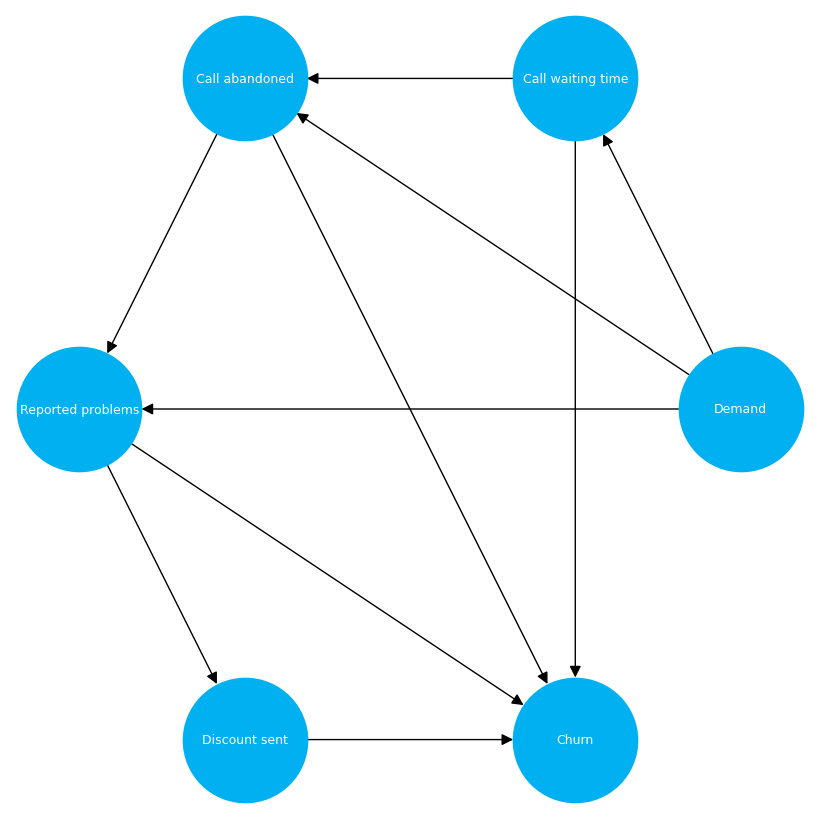

In [5]:
plot_graph(input_graph=graph_actual, node_lookup=node_lookup)

In [6]:
def data_generator(max_call_waiting, inbound_calls, call_reduction):
    '''
     A data generating function that has the flexibility to reduce the value of node 0 (Call waiting time) - this enables us to calculate ground truth counterfactuals

    Args:
        max_call_waiting (int): Maximum call waiting time in seconds
        inbound_calls (int): Total number of inbound calls (observations in data)
        call_reduction (float): Reduction to apply to call waiting time

    Returns:
        DataFrame: Generated data
    '''
    
    df = pd.DataFrame(columns=node_lookup.values())

    df[node_lookup[0]] = np.random.randint(low=10, high=max_call_waiting, size=(inbound_calls)) # Demand
    df[node_lookup[1]] = (df[node_lookup[0]] * 0.5) * (call_reduction) + np.random.normal(loc=0, scale=40, size=inbound_calls) # Call waiting time
    df[node_lookup[2]] = (df[node_lookup[1]] * 0.5) + (df[node_lookup[0]] * 0.2) + np.random.normal(loc=0, scale=30, size=inbound_calls) # Call abandoned
    df[node_lookup[3]] = (df[node_lookup[2]] * 0.6) + (df[node_lookup[0]] * 0.3) + np.random.normal(loc=0, scale=20, size=inbound_calls) # Reported problems
    df[node_lookup[4]] = (df[node_lookup[3]] * 0.7) + np.random.normal(loc=0, scale=10, size=inbound_calls) # Discount sent
    df[node_lookup[5]] = (0.10 * df[node_lookup[1]] ) + (0.30 * df[node_lookup[2]]) + (0.15 * df[node_lookup[3]]) + (-0.20 * df[node_lookup[4]]) # Churn

    return df

In [7]:
# Generate data
np.random.seed(999)
df = data_generator(max_call_waiting=600, inbound_calls=10000, call_reduction=1.00)
df

,Demand,Call waiting time,Call abandoned,Reported problems,Discount sent,Churn
0,458,215.564320,184.203737,270.827027,180.738762,81.293855
1,358,231.684552,206.417015,246.048185,168.878231,88.225141
2,491,240.964451,179.425270,232.651769,153.540137,82.113764
3,235,142.553731,148.626154,175.441389,138.295402,57.500347
4,485,256.927178,281.410095,326.223968,231.282762,112.792789
...,...,...,...,...,...,...
9995,376,178.442600,214.846263,219.720565,153.335835,84.589057
9996,25,-9.596745,-60.570855,-18.278805,-0.669854,-21.738781
9997,420,255.145635,261.184659,291.118868,191.667868,109.204218
9998,292,217.439395,139.453178,154.491528,98.476326,67.058357


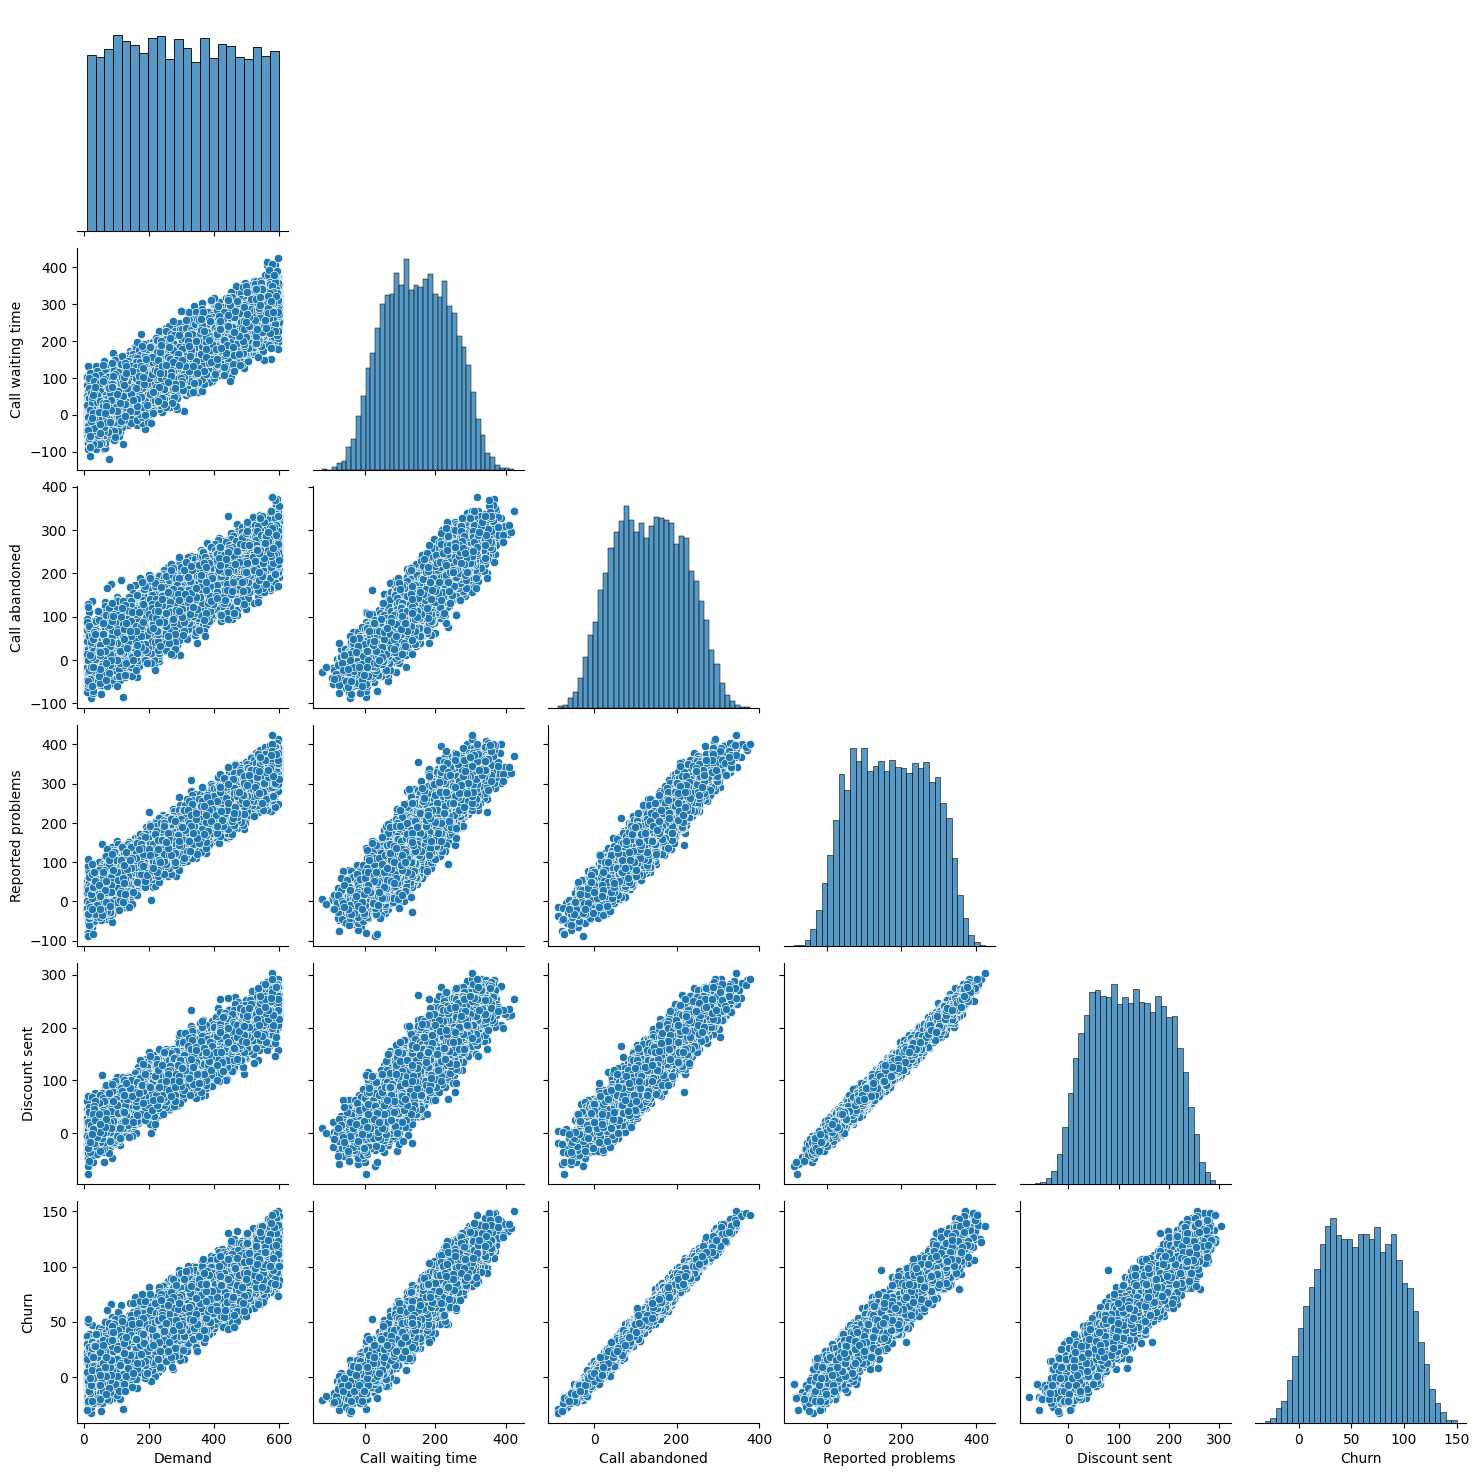

In [8]:
sns.pairplot(df, corner=True)

# <ins>Applying the PC algorithm</ins>

The Python package gCastle has several causal discovery algorithms implemented, including the PC algorithm. When we feed the algorithm our samples we receive back the learned causal graph (in the form of an adjacency matrix).

gCastle also has several evaluation metrics available, including gScore. The gScore of our learned graph is 0! Why has it done so poorly? On closer inspection of the learned graph, we can see that it correctly identified the undirected graph and then struggled to orient the edges.

In [13]:
# Apply PC method to learn graph
pc = PC(variant='stable')
pc.learn(df)
graph_pred = pc.causal_matrix

graph_pred

Tensor([[0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 1, 1, 0, 0, 0]])

In [15]:
# GScore
metrics = MetricsDAG(
    B_est=graph_pred, 
    B_true=graph_actual)
metrics.metrics['gscore']

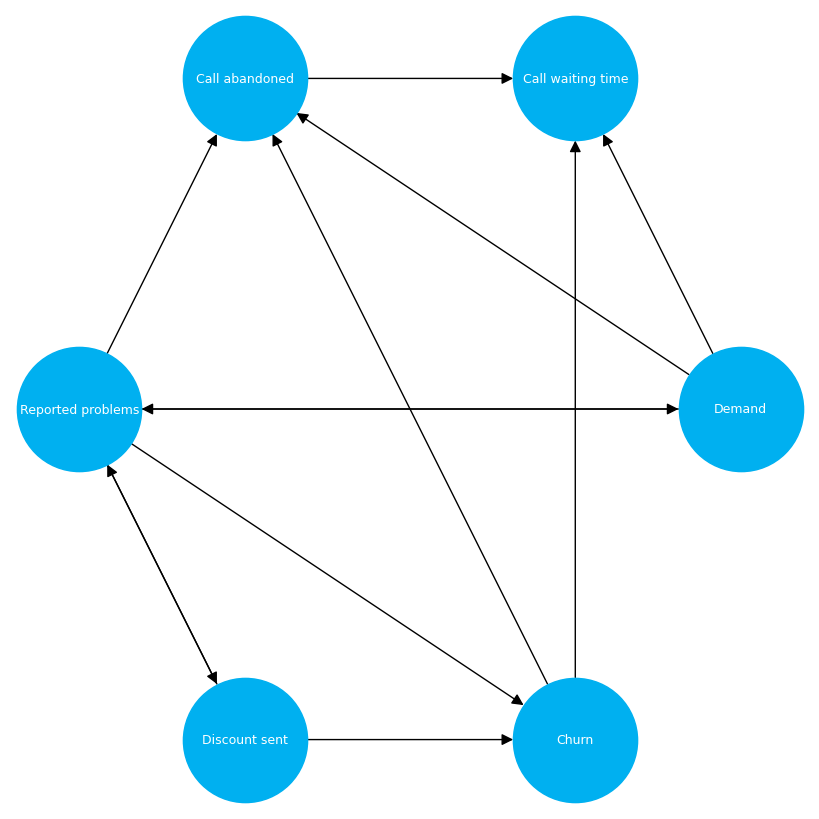

In [16]:
plot_graph(input_graph=graph_pred, node_lookup=node_lookup)

# <ins>Evaluating the undirected graph</ins>

To build on the learning from applying the PC algorithm, we can use gCastle to extract the undirected causal graph that was learned. When we transform our ground truth graph into an undirected adjacency matrix and then calculate the gScore using the learned undirected causal graph we get a gScore of 1.00. 

We have accurately learned an undirected graph - could we use expert domain knowledge to direct the edges? The answer to this will vary across different use cases, but it is a reasonable strategy.

In [43]:
# Apply PC method to learn skeleton
skeleton_pred, sep_set = find_skeleton(df.to_numpy(), 0.05, 'fisherz')

skeleton_pred

array([[0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0., 1.],
       [1., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 1., 1., 1., 1., 0.]])

In [44]:
# Transform the ground truth graph into an undirected adjacency matrix
skeleton_actual = graph_actual + graph_actual.T
skeleton_actual = np.where(skeleton_actual > 0, 1, 0)

In [45]:
# GScore
metrics = MetricsDAG(
    B_est=skeleton_pred, 
    B_true=skeleton_actual)
metrics.metrics['gscore']

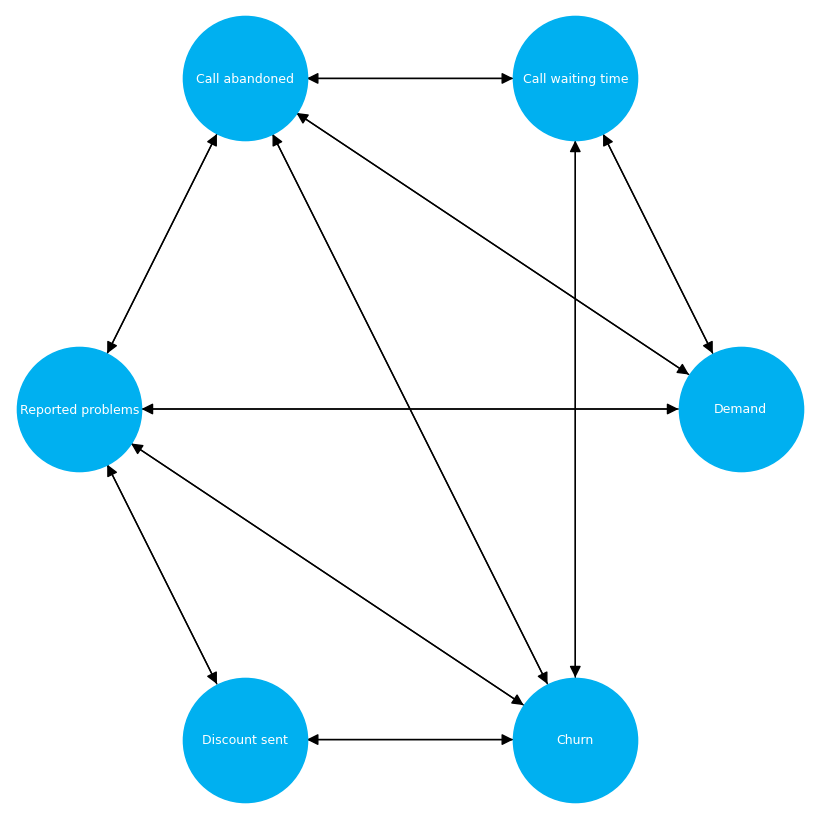

In [46]:
plot_graph(input_graph=skeleton_pred, node_lookup=node_lookup)

# <ins>Making causal discovery work in real-world business settings</ins>
- We need to start seeing causal discovery as an essential EDA step in any causal inference project.
  - However, we also need to be transparent about its limitations.
  - Causal discovery is a tool that needs complementing with expert domain knowledge.
- Be pragmatic with the assumptions.
  - Can we ever expect to observe all confounders? Probably not. However, with the correct domain knowledge and extensive data gathering, it is feasible that we could observe all the key confounders.
- Pick an algorithm where we can apply constraints to incorporate expert domain knowledge - gCastle allows us to apply constraints to the PC algorithm.
- Initially work on identifying the undirected causal graph and then share this output with domain experts and use them to help orient the graph.
- Be cautious when using proxy variables and consider enforcing constraints on relationships we strongly believe exist.
  - For example, if include Google trends data as a proxy for product demand, we may need to enforce constraints in terms of this driving sales.

# <ins>Future work</ins>
- What if we have non-linear relationships? Can the PC algorithm handle this?
- What happens if we have unobserved confounders? Can the FCI algorithm deal with this situation effectively?
- How do constraint-based, score-based, functional-based and gradient-based methods compare?